In [1]:
import pandas as pd
import json

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series, DataFrame
%matplotlib inline

Сделать новый файл с матчами

In [2]:
src = []
with open( "matches.json", 'r', encoding='utf-8', newline='' ) as f:
    src = json.load(f)
print(f"Loaded {len(src)} matches")
dst = []
for m in src:
    m_new = {}
    for k,v in m.items():
        if k in ["home", "away"]:
            m_new[k] = v["name"]
        # elif k == "quarters":
        #     m_new["q1"] = v["1"]
        #     m_new["q2"] = v["2"]
        #     m_new["q3"] = v["3"]
        #     m_new["q4"] = v["4"]
        #     m_new["ot"] = v["5"]
        elif k == "odds":
            m_new["odd_h"] = v["home"]
            m_new["odd_a"] = v["away"]
            for ttl in v['total']:                
                if float( ttl[1] ) < 1.97  and float( ttl[2] ) < 2.0 :
                    m_new['total'] = ttl[0]
        elif k in ["score", "date"]:
            m_new[k] = v
    dst.append(m_new)   

with open( "matches_clean.json", 'w', encoding='utf-8', newline='' ) as f:
    json.dump(dst, f, ensure_ascii=False, indent=4)

Loaded 443 matches


In [3]:
all_matches = pd.read_json("matches_clean.json" )
all_matches["score_h"] = all_matches["score"].apply( lambda x: int (x.split(":")[0] )  ) 
all_matches["score_a"] = all_matches["score"].apply( lambda x: int (x.split(":")[1] )  ) 
all_matches["total_sum"] = all_matches["score_h"] + all_matches["score_a"]
del all_matches["score"]

all_matches.head(10)

,date,home,away,odd_h,odd_a,total,score_h,score_a,total_sum
0,2022-12-18 05:00:00,Финикс Санс,Нью-Орлеан Пеликанс,1.67,2.21,228.5,118,114,232
1,2022-12-18 04:00:00,Кливленд Кавальерс,Даллас Маверикс,1.26,3.95,212.5,100,99,199
2,2022-12-18 04:00:00,Милуоки Бакс,Юта Джаз,1.77,2.06,228.0,123,97,220
3,2022-12-18 04:00:00,Оклахома-Сити Тандер,Мемфис Гриззлис,5.60,1.15,229.5,115,109,224
4,2022-12-18 04:00:00,Хьюстон Рокетс,Портленд Трэйл Блэйзерс,2.22,1.67,228.5,95,107,202
5,2022-12-18 01:00:00,Сан-Антонио Спёрс,Майами Хит,3.60,1.29,223.5,101,111,212
6,2022-12-18 00:00:00,Лос-Анджелес Клипперс,Вашингтон Уизардс,1.49,2.65,219.0,102,93,195
7,2022-12-17 06:00:00,Лос-Анджелес Лейкерс,Денвер Наггетс,2.06,1.77,238.0,126,108,234
8,2022-12-17 04:30:00,Даллас Маверикс,Портленд Трэйл Блэйзерс,1.56,2.45,226.5,130,110,240
9,2022-12-17 04:00:00,Оклахома-Сити Тандер,Миннесота Тимбервулвз,1.53,2.50,235.0,110,112,222


In [31]:
total = all_matches.copy()
total["delta"] = total["total_sum"] - total["total"]
del total["date"]
total = total.reset_index(drop=True)


In [32]:
total.tail()

,home,away,odd_h,odd_a,total,score_h,score_a,total_sum,delta
438,Торонто Рэпторс,Кливленд Кавальерс,1.70,2.16,217.0,108,105,213,-4.0
439,Детройт Пистонс,Орландо Мэджик,1.65,2.25,216.5,113,109,222,5.5
440,Индиана Пэйсерс,Вашингтон Уизардс,2.17,1.70,229.0,107,114,221,-8.0
441,Голден Стэйт Уорриорз,Лос-Анджелес Лейкерс,1.31,3.50,224.0,123,109,232,8.0
442,Бостон Селтикс,Филадельфия Сиксерс,1.67,2.22,216.5,126,117,243,26.5


In [96]:
def get_team( team_name ) :    
    home = total[total["home"] == team_name][["odd_h", "total", "delta" ]]
    home = home.rename(columns={"odd_h": "odd", "match_score" : "match"})

    away =  total[total["away"] == team_name][["odd_a", "total", "delta" ]]
    away = away.rename(columns={"odd_a": "odd", "match_score" : "match"})
    team = pd.concat([home,away]).reset_index(drop=True)
    return team

def get_fav( val ):
    if val >= 1.0 and val < 1.5 :
        return "HIGH"
    elif val >= 1.5 and val < 2.0 :
        return "MED"
    elif val >= 2.0 and val < 3.0 :
        return "LOW"
    elif val >= 3.0  :
        return "FEW"
    
def complete_match(home, away):
    team = get_team(home)
    team["fav"] = team["odd"].apply( lambda x : get_fav(x) )
    team['id'] = "home"    
    team2 = get_team(away)
    team2["fav"] = team2["odd"].apply( lambda x : get_fav(x) )
    team2['id'] = "away"
    g = sns.relplot(
        data=pd.concat([team, team2]),
        x="total", y="delta",
        hue = "fav", col="fav", size="id", style="id"
    )
    
    

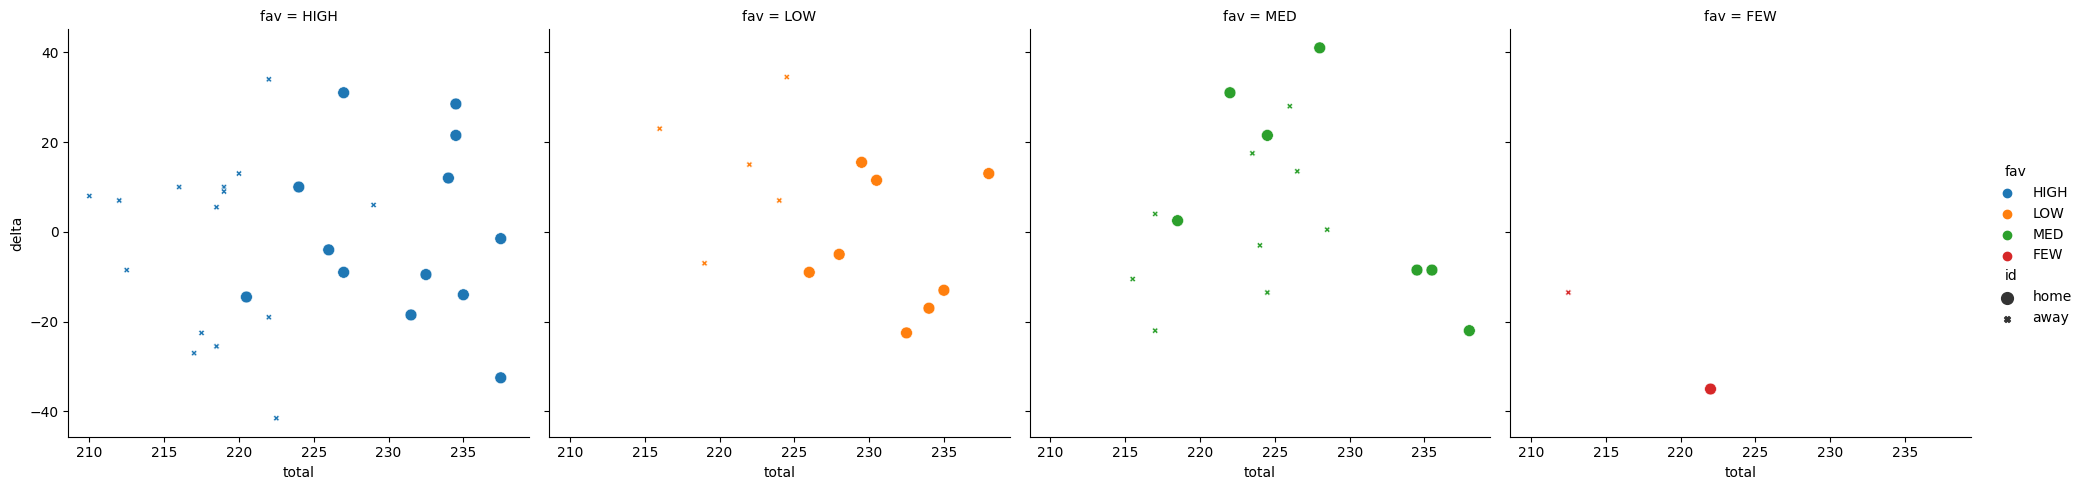

In [100]:
# complete_match( "Кливленд Кавальерс", "Юта Джаз" )
# complete_match( "Филадельфия Сиксерс", "Торонто Рэпторс" )
# complete_match( "Атланта Хокс", "Орландо Мэджик" )
complete_match( "Миннесота Тимбервулвз", "Даллас Маверикс" )


